In [1]:
#########################################
# Chargement des bibliothèques          #
#########################################
import os
import pandas
import pandas_profiling
import numpy
from datetime import date,datetime,timedelta
import pylab
import matplotlib.pyplot  as pyplot
import seaborn
import graphviz
from sklearn import tree, preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
# Désactivation des avertissements : pb mémoire, packages obsolètes, ...
import warnings
warnings.filterwarnings('ignore')

# paramétrage des options
pandas.set_option('display.max_rows', 500)
pandas.set_option('display.max_columns', 500)
pandas.set_option('display.width', 1000)
%matplotlib inline

path ="/home/user/Documents/STA211-Datamining/Projet_STA"
os.chdir(path)


In [6]:
%load_ext rpy2.ipython

In [22]:
%%R -w 5 -h 5 --units in -r 200
#Définition des librairies
library(jsonlite)
library(Hmisc)
library(FactoMineR)
library(rpart)
library(rpart.plot)

In [ ]:
%%R
#Chargement du jeu de données
path="/home/user/Documents/STA211-Datamining/Projet_STA/"
Airbnb<-fromJSON(paste(path,"airbnb_V2.json",sep=""))
sapply(Airbnb,class)
summary(Airbnb)


In [11]:
%%R
character_vars <- lapply(Airbnb, class) == "character"
Airbnb[, character_vars] <- lapply(Airbnb[, character_vars], as.factor)
#définition de la variable arrondissement comme qualitative
Airbnb$arrondissement <- as.factor(Airbnb$arrondissement ) 
sapply(Airbnb,class)

                        _id                accommodates 
                  "integer"                    "factor" 
                  bathrooms                    bed_type 
                   "factor"                    "factor" 
                   bedrooms                        beds 
                   "factor"                    "factor" 
              property_type                   room_type 
                   "factor"                    "factor" 
             arrondissement      host_identity_verified 
                   "factor"                    "factor" 
          host_is_superhost               host_listings 
                   "factor"                    "factor" 
              host_response                  host_since 
                   "factor"                    "factor" 
              cancel_policy            instant_bookable 
                   "factor"                    "factor" 
            availability_30            availability_365 
                  "numeric"    

In [25]:
%%R
Airbnb <- subset(Airbnb, select = -c(total_price) )

In [32]:
%%R
AirbnbTree <- rpart(price_level~.,data=Airbnb,control=rpart.control(minsplit=500,cp = 0.01, xval=20))
printcp(AirbnbTree)


Classification tree:
rpart(formula = price_level ~ ., data = Airbnb, control = rpart.control(minsplit = 500, 
    cp = 0.01, xval = 20))

Variables actually used in tree construction:
[1] accommodates     arrondissement   availability_365 bathrooms       
[5] bedrooms         host_listings    room_type       

Root node error: 23350/41084 = 0.56835

n=41084 (10 observations deleted due to missingness)

        CP nsplit rel error  xerror      xstd
1 0.145953      0   1.00000 1.00000 0.0042996
2 0.023212      1   0.85405 0.85405 0.0043384
3 0.016681      2   0.83084 0.83084 0.0043336
4 0.016445      4   0.79747 0.82107 0.0043306
5 0.015460      5   0.78103 0.78450 0.0043148
6 0.011199      6   0.76557 0.76732 0.0043047
7 0.010407      8   0.74317 0.74921 0.0042923
8 0.010000      9   0.73276 0.73709 0.0042829


In [33]:
%%R
bestcp <- AirbnbTree$cptable[which.min(AirbnbTree$cptable[,"xerror"]),"CP"]

# Step3: Prune the tree using the best cp.
AirbnbTree.pruned <- prune(AirbnbTree, cp = bestcp)

In [34]:
%%R
# confusion matrix (training data)
conf.matrix <- table(Airbnb$price_level, predict(AirbnbTree.pruned,type="class"))
rownames(conf.matrix) <- paste("Actual", rownames(conf.matrix), sep = ":")
colnames(conf.matrix) <- paste("Pred", colnames(conf.matrix), sep = ":")
print(conf.matrix)


Error in table(Airbnb$price_level, predict(AirbnbTree.pruned, type = "class")) : 
  tous les arguments doivent avoir la même longueur


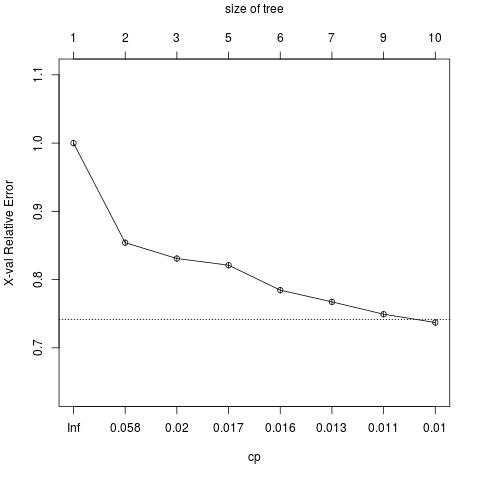

In [36]:
%%R
plotcp(AirbnbTree)

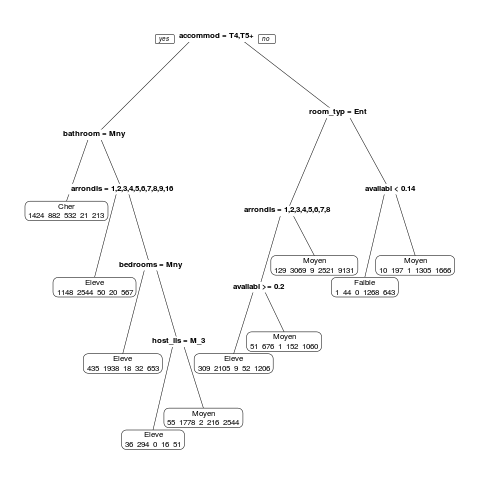

In [37]:
%%R
prp(AirbnbTree,extra=1)

cex 0.816   xlim c(0, 1)   ylim c(0, 1)


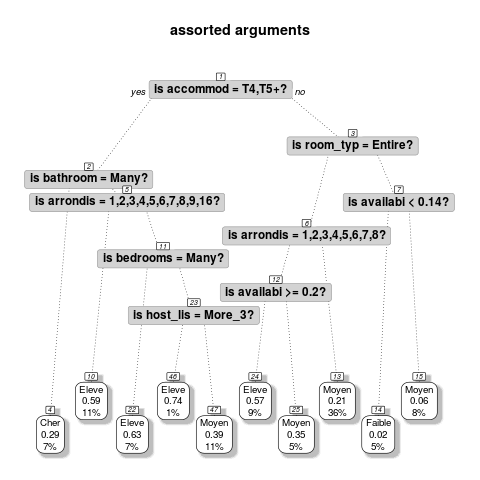

In [47]:
%%R
prp(AirbnbTree, main="assorted arguments",
    extra=106,           # display prob of survival and percent of obs
    nn=TRUE,             # display the node numbers
    fallen.leaves=TRUE,  # put the leaves on the bottom of the page
    shadow.col="gray",   # shadows under the leaves
    branch.lty=3,        # draw branches using dotted lines
    branch=.5,           # change angle of branch lines
    faclen=0,            # faclen=0 to print full factor names
    trace=1,             # print the automatically calculated cex
    split.cex=1.2,       # make the split text larger than the node text
    split.prefix="is ",  # put "is " before split text
    split.suffix="?",    # put "?" after split text
#    col=cols, border.col=cols,   # green if survived
    split.box.col="lightgray",   # lightgray split boxes (default is white)
    split.border.col="darkgray", # darkgray border on split boxes
    split.round=.5)              # round the split box corners a tad